# 第6回課題 写真から線画のイラストを作ろう！

授業では2次元フィルタリングについて勉強しましたね。   
異なる2次元フィルタを組み合わせることによって、さまざまな画像変換が行えるようになります。   
ここでは、写真をイラストにする手法を試してみたいと思います。

<H2><font color="red">今回は原画像を皆さんに用意してもらうことにします。</font></H2><BR>

- 原画像はスマホで撮影してパソコンに取り込んだり、パソコン内蔵のカメラを使って撮影したり、パブリックドメインの画像をWebからダウンロードすることで用意してください
- 原画像はこの課題がおかれているフォルダなどにおいて、その写真のパスを、このノートブックの一番最初のコードセルにある変数`imgfile`に代入してください
- 各処理において、それぞれパラメータを調整してきれいな線画を作成してください。
    
<H2><font color="red">課題を提出する際は、画像が表示されている状態で保存し、このmp_ex6.ipynbファイルのみを提出してください。</font></H2>

## 1. 写真の読み込み

まずは元の画像を読み込みましょう。

すでに説明した通り、opencvで画像を読み込むと、RGBではなくBGRの順番になりますので、cv2.cvtColorでBGRをRGBに変換するのを忘れないようにしましょう。   
また、線画にするための処理では色情報は不要なので、ここでグレースケール画像に変換しておきます。

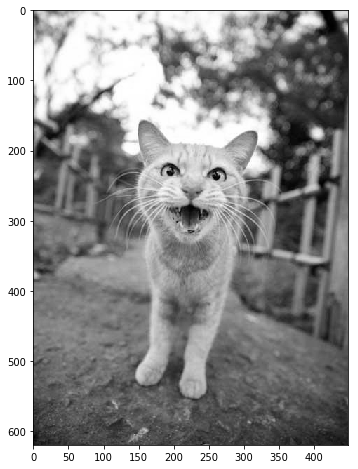

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

imgfile = 'cat.jpg' # <-- ここに、皆さんが用意した画像のパスを記入してください
img = cv2.cvtColor(cv2.imread(imgfile), cv2.COLOR_BGR2RGB) # BGRをRGBに変換
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # フィルタリング用にグレースケール画像に変換

plt.figure(figsize=(12, 8))
plt.imshow(img_gray, 'gray')


## 2. ノイズ除去 (Noise reduction by Bilateral Filter)

きれいな線画を作るためには、細かい線はあらかじめ除去しておく必要があります。   
しかし、輪郭線がなくなると困りますよね。   
そこでここではバイラテラルフィルタを使いましょう。  

バイラテラルフィルタは、画像の各画素について次のような処理をするフィルタです。

- 周辺の画素の輝度値に比べてその画素の輝度が大きく異なる場合は輝度をあまり変化させず、    
- 周辺の画素の輝度値に比べてその画素の輝度があまり変わらない場合はガウシアンフィルタをかけてぼかす

`opencv`の`bilateralFilter`は以下の引数を受け取ります。   

1. 変換対象の画像
1. フィルタのサイズ
1. 注目している画素が周辺とどの程度違うとガウシアンフィルタをつよくかけるかを決めるパラメータ。これもガウス関数の標準偏差。
1. 離れた距離の画素の輝度をどの程度多く取るかを決めるパラメータ。ガウシアンフィルタの標準偏差に相当。

上の3つのパラメータを調節してください。

輪郭線を残したまま細かいまだら模様を消してくれるので、美肌フィルタとも呼ばれます。

バイラテラルフィルタは何度かかけるほうが効果的です。

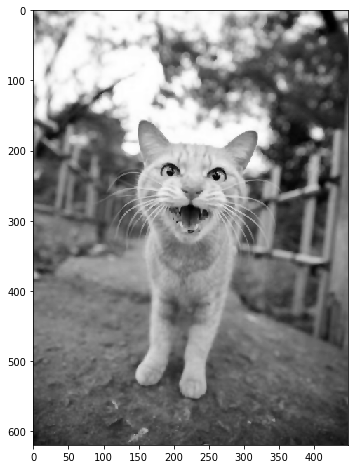

In [43]:
img_bilateral = img_gray
for i in range(3):
    img_bilateral = cv2.bilateralFilter(img_bilateral, # 入力画像
                                        1, # フィルタサイズ
                                        15, # 周辺画素の輝度差に対する重みを決めるガウス関数の標準偏差
                                        3) # 周辺画素の距離に対する重みを決めるガウス関数の標準偏差

plt.figure(figsize=(12, 8))
plt.imshow(img_bilateral, 'gray')


## 3. エッジ抽出 (Edge Detection)

ここでは`ImageProcessing3.ipynb`で使ったラプラシアンフィルタを適用しましょう。  
フィルタのサイズである`ksize`を調節してください。

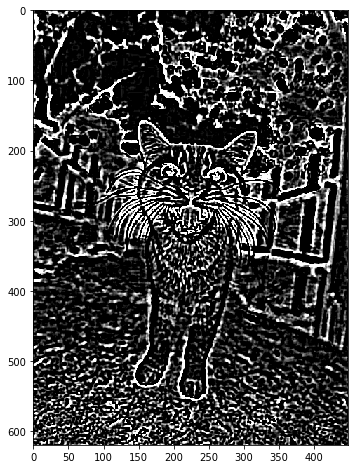

In [44]:
img_laplacian =  cv2.Laplacian(img_bilateral, cv2.CV_8U, ksize=5)

plt.figure(figsize=(12, 8))
plt.imshow(img_laplacian, 'gray')


## 4. 二値化 (Image Binalization)

グレースケール画像を白黒からなる二値画像に変換します。   
閾値`TH`を調節してもいいですし、`ImageBinalization.ipynb`で紹介した大津の二値化を使っても構いません。

計算された閾値: 108.0


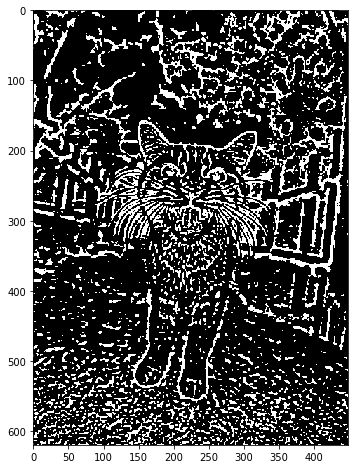

In [45]:
TH = 80
ret, img_binary = cv2.threshold(img_laplacian, 0, 255, cv2.THRESH_OTSU) # 大津の二値化
#ret, img_binary = cv2.threshold(img_laplacian, TH, 255, cv2.THRESH_BINARY) # 閾値処理

print('計算された閾値:', ret)
plt.figure(figsize=(12, 8))
plt.imshow(img_binary,'gray')


## 5. 二値画像のノイズ除去

二値画像におけるノイズとは、黒い空間の中に浮かぶ小さな白い小島のようなものです。   
大きな島を残しつつ、小島を消すために、島の沿岸から島をぐるっと削り、また島の沿岸をぐるっと埋め立てることを考えましょう。

小さな島は、何度か削るとなくなってしまうので、膨張させる段階になったときにはすでに存在しなくなります。   
一方、大きな島は存在し続けるので、膨張させると元の島に近づきます。

削る範囲を決める`kernel`のサイズと、何回削るのかを決める`iterations`のパラメータを調整してください。

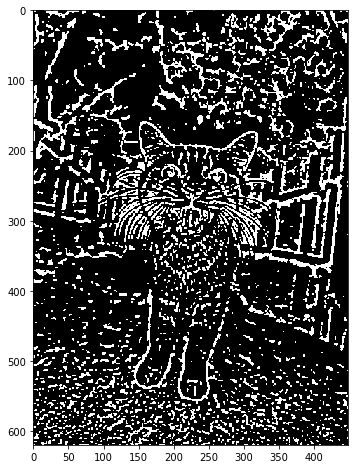

In [82]:
import numpy as np

kernel = np.ones((2,2),np.uint8)
img_erosion = cv2.erode(img_binary,kernel,iterations = 1) # 白の領域を縮退させる
img_dilation = cv2.dilate(img_erosion,kernel,iterations = 1) # 白の領域を膨張させる

plt.figure(figsize=(12, 8))
plt.imshow(img_dilation,'gray')


## 6. 細線化 (Thinning)

画素が２以上の太さを持つ線を、線を切らないように周りから削っていき、画素１の太さの線にする手法です。   
`opencv`の発展的な関数である`ximgproc`のなかに`thinning`という関数があるのでこれを使いましょう。   

細線化のアルゴリズムには以下の2つから選ぶことができます。

- Zhang-Suenの手法：THINNING_ZHANGSUEN
- Guo-Hallの手法：THINNING_GUOHALL

下の出力画像上で線が途切れているように見えるかもしれませんが、それは画面サイズが小さいため、画像を縮小して表示する際に消えたように見えるためで、拡大すれば途切れていないことがわかるはずです。

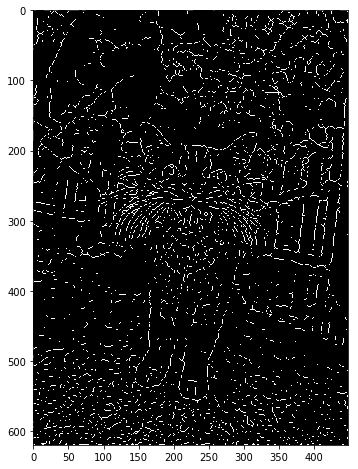

In [83]:
#img_thinning = cv2.ximgproc.thinning(img_dilation, None, cv2.ximgproc.THINNING_ZHANGSUEN) 
img_thinning = cv2.ximgproc.thinning(img_dilation, None, cv2.ximgproc.THINNING_GUOHALL)
    
plt.figure(figsize=(12, 8))
plt.imshow(img_thinning,'gray')


## 7. 線を太くする

「5. 二値画像のノイズ除去」で使った膨張処理を適用して線を太くします。   
どれだけ太くするかは`kernel`のサイズや繰り返し回数`iterations`を調節してください。

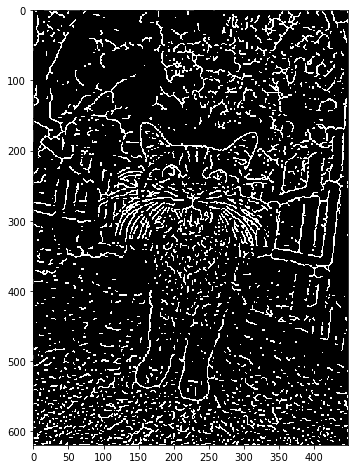

In [89]:
import numpy as np

kernel = np.ones((2,2),np.uint8)
img_dilation = cv2.dilate(img_thinning, kernel, iterations = 1)

plt.figure(figsize=(12, 8))
plt.imshow(img_dilation,'gray')


## 8. 白と黒を入れ替える

線画は普通、白地に黒い線で書きますから、白と黒を入れ替えましょう。   
これで完成です。  

**この画像がきれいになるように上で適用した様々なフィルタのパラメータを調節してください！**

True

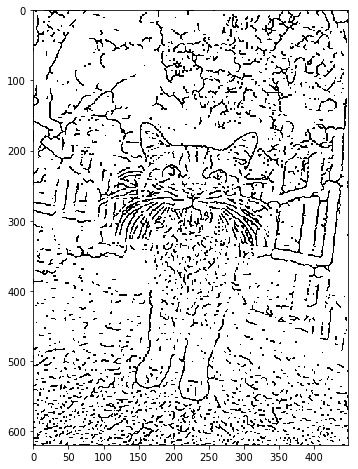

In [90]:
img_bitwise = cv2.bitwise_not(img_dilation) # 白と黒を入れ替え

plt.figure(figsize=(12, 8))
plt.imshow(img_bitwise,'gray')

cv2.imwrite('img/LineDrawing.png', img_bitwise)